In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle as pkl
import utils
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal
import importlib
from tqdm.notebook import tqdm
# other options
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'w'
np.set_printoptions(suppress=True)
import xarray as xa

from numba import jit

# Find proper K

In [99]:
def draw_kmeans_summary(kobj):
    
    def get_moment(kobj, varname):
        m = np.average(kobj[varname], axis=1)
        s = np.std(kobj[varname], axis=1)
        return m, s

    km, ks = get_moment(kobj, "kcoeff_sets")
    sm, ss = get_moment(kobj, "scoeff_sets")
    num_clusters = kobj["num_clusters"]
    
    fig = plt.figure(figsize=(5, 6))

    plt.subplot(211)
    l1 = plt.plot(num_clusters, km, c='k', label="k coef")
    plt.fill_between(num_clusters, km-ks, km+ks, alpha=0.5, color='k', edgecolor='none')
    plt.xticks(np.arange(num_clusters[0], num_clusters[-1], 2))
    plt.xlabel(r"$K$", fontsize=14)
    plt.ylabel("K-coef")

    plt.twinx()
    l2 = plt.plot(num_clusters, sm, c='r', label='Silhouette coef')
    plt.fill_between(num_clusters, sm-ss, sm+ss, alpha=0.5, color='r', edgecolor='none')
    plt.ylabel("S-coef")

    ln = l1 + l2
    plt.legend(ln, [l.get_label() for l in ln], edgecolor='k', loc="center right")

    plt.subplot(212)
    l1 = plt.plot(num_clusters[1:], km[:-1] - km[1:], c='k', label="k coef")
    plt.xticks(np.arange(num_clusters[0], num_clusters[-1], 2))
    plt.xlabel(r"$K$", fontsize=14)
    plt.ylabel(r"$\Delta$K-coef")

    plt.twinx()
    l2 = plt.plot(num_clusters[1:], sm[:-1] - sm[1:], c='r', label='Silhouette coef')
    plt.ylabel(r"$\Delta$S-coef")

    plt.tight_layout()

    # utils.save_fig("kmeans_perform_%s"%(tag), fdir="./fig")
    # plt.show()
    
    return fig
    

# build consensus matrix
@jit(nopython=True)
def get_consensus_mat(cluster_id_set):
    # cluster_id_set: (num_itr * N)
    N = cluster_id_set.shape[1]
    cmat = np.zeros((N, N))
    for cid in cluster_id_set:
        for nr in range(N):
            for nc in range(nr+1, N):
                if cid[nr] == cid[nc]:
                    cmat[nr, nc] += 1
    cmat /= len(cluster_id_set)
    
    # fill
    for nr in range(N):
        cmat[nr, nr] = 1
        for nc in range(nr+1, N):
            cmat[nc, nr] = cmat[nr, nc]
    
    return cmat


""" Use for calculating CDF different"""
def get_val(x0, x, y):
    if x0 in x:
        return y[np.where(x == x0)[0]]
    
    # get left point
    dx = x0 - x; dx[dx < 0] += 100
    idl = np.argmin(dx)
    
    # get right point
    dx = x - x0; dx[dx < 0] += 100
    idr = np.argmin(dx)
    
    dxl = x0 - x[idl]
    dxr = x[idr] - x0

    dy = y[idr] - y[idl]
    return dy / (dxl + dxr) * dxl + y[idl]

# ============ matrix sorting =============== #
def sort_matrix(dist_mat, method="ward"):
    
    from scipy.spatial.distance import squareform
    from scipy.cluster.hierarchy import linkage
    
    def seriation(linkage_data, cur_index):
        if cur_index < N:
            return [cur_index]
        else:
            left = int(linkage_data[cur_index-N, 0])
            right = int(linkage_data[cur_index-N, 1])
            return (seriation(linkage_data, left) + seriation(linkage_data, right))
    
    flag_flip = False
    if np.all(np.diag(dist_mat) == 1):
        print("convert to distance metric")
        flag_flip = True
        dist_mat = 1 - dist_mat
    
    N = len(dist_mat)
    square_mat = squareform(dist_mat)
    res_linkage = linkage(square_mat, method=method)
    res_order   = seriation(res_linkage, 2*N-2)
    
    sort_mat = dist_mat.copy()
    sort_mat = sort_mat[res_order, :]
    sort_mat = sort_mat[:, res_order]
    
    if flag_flip:
        sort_mat = 1 - sort_mat
    
    return sort_mat, res_linkage, res_order


## Total population result

In [101]:
tag = "tot" # tot, sub

with open("./data/kmeans_%s_n2.pkl"%(tag), 'rb') as fp:
    kobj_tot = pkl.load(fp)

### Draw kmeans summary

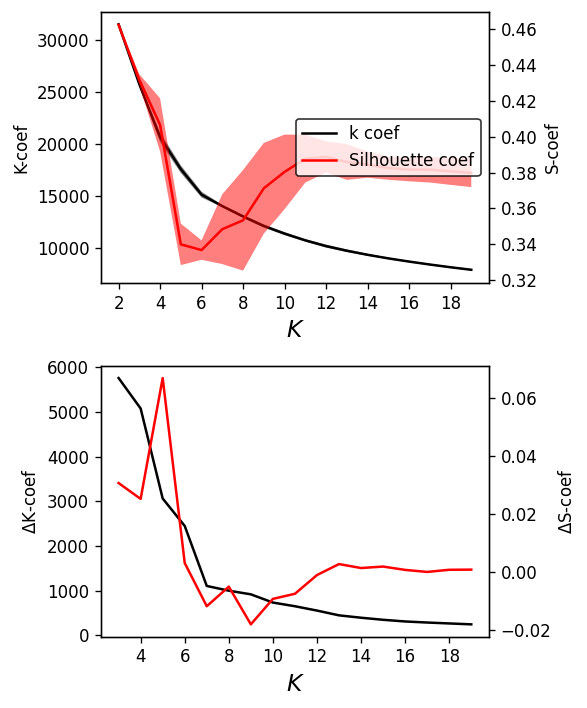

In [102]:
fig = draw_kmeans_summary(kobj_tot)
# utils.save_fig("kmeans_perform_%s"%(tag), fdir="./fig")
plt.show()

### Consensus matrix

In [52]:
from tqdm.notebook import tqdm

cmats_tot = [] # consensus matrix
for cid_set in tqdm(kobj_tot["cid_sets"]):
    cmats_tot.append(get_consensus_mat(cid_set))

  0%|          | 0/18 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Visualization

convert to distance metric
convert to distance metric
convert to distance metric
convert to distance metric


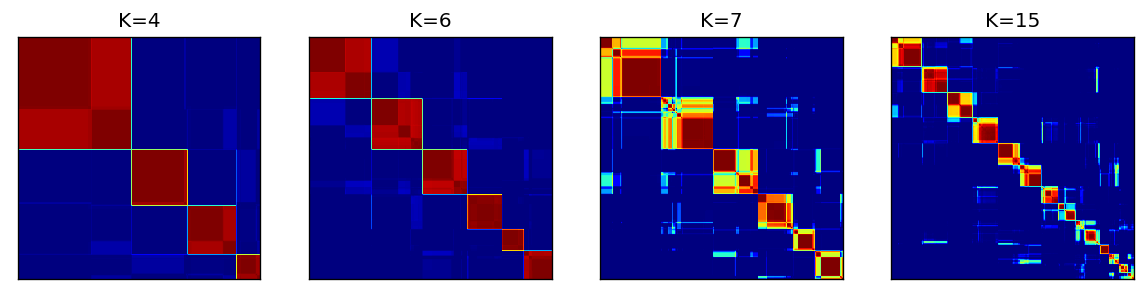

In [ ]:
nid_show = [2, 4, 5, 13]

plt.figure(dpi=120, figsize=(12, 3))
for n, nid in enumerate(nid_show):
    plt.subplot(1, 4, n+1)
    sort_mat, _, _ = sort_matrix(cmats_tot[nid])
    plt.imshow(sort_mat, cmap="jet", vmax=1, vmin=0)
    plt.title("K=%d"%(kobj_tot["num_clusters"][nid]))
    plt.xticks([])
    plt.yticks([])
plt.show()
    

### CDF of consensus matrix

In [ ]:
cdf_sets_tot = []
edges = np.linspace(0, 1, 51)

for cm in cmats_tot:
    c, bins = np.histogram(cm.flatten(), bins=edges)
    pdf = c / (len(cm[0]))**2
    cdf_sets_tot.append(np.cumsum(pdf))


#### draw cdf & PAC

save to ./fig/consensus_cdf_tot_2023921.png


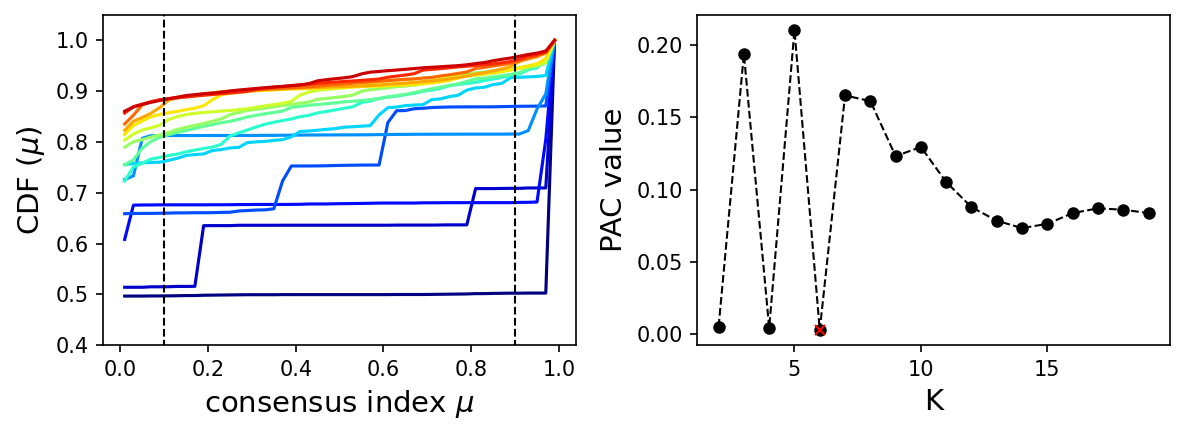

K = 6


In [ ]:
# ref: https://www.nature.com/articles/srep06207

cs = hhtools.get_palette("jet")
x = (edges[1:] + edges[:-1])/2

xwin = [0.1, 0.9]

pac_vals = []
for cdf in cdf_sets_tot:
    c0 = get_val(xwin[0], x, cdf)
    c1 = get_val(xwin[1], x, cdf)
    pac_vals.append(c1 - c0)

plt.figure(dpi=150, figsize=(8, 3))

plt.subplot(121)
for n in range(15):
    plt.plot(x, cdf_sets_tot[n], c=cs(n/15), lw=1.5)
plt.plot([xwin[0]]*2, [0, 1.1], 'k--', lw=1)
plt.plot([xwin[1]]*2, [0, 1.1], 'k--', lw=1)

plt.xlabel(r"consensus index $\mu$", fontsize=14)
plt.ylabel(r"CDF ($\mu$)", fontsize=14)
plt.ylim([0.4, 1.05])

plt.subplot(122)

nk = 4
num_clusters = kobj_tot["num_clusters"]

plt.plot(num_clusters, pac_vals, 'k.--', lw=1, ms=10)
plt.plot(num_clusters[nk], pac_vals[nk], 'rx', lw=1, ms=5)
plt.ylabel("PAC value", fontsize=14)
plt.xlabel("K", fontsize=14)
plt.tight_layout()

utils.save_fig("consensus_cdf_tot")
plt.show()

print("K = %d"%(num_clusters[nk]))

In [ ]:
# save proper K
data = dict(
    num_cluster=num_clusters[nk],
    consensus_mat=cmats_tot[nk],
    fdata="./data/kmeans_tot.pkl",
    date=utils.get_date_string()
)

with open("./data/kmeans_tot_opt_n2.pkl", 'wb')  as fp:
    pkl.dump(data, fp)

### Sub population result

In [97]:
with open("./data/kmeans_sub_n2.pkl", 'rb') as fp:
    kobj_sub = pkl.load(fp)

### Draw kmeans summary

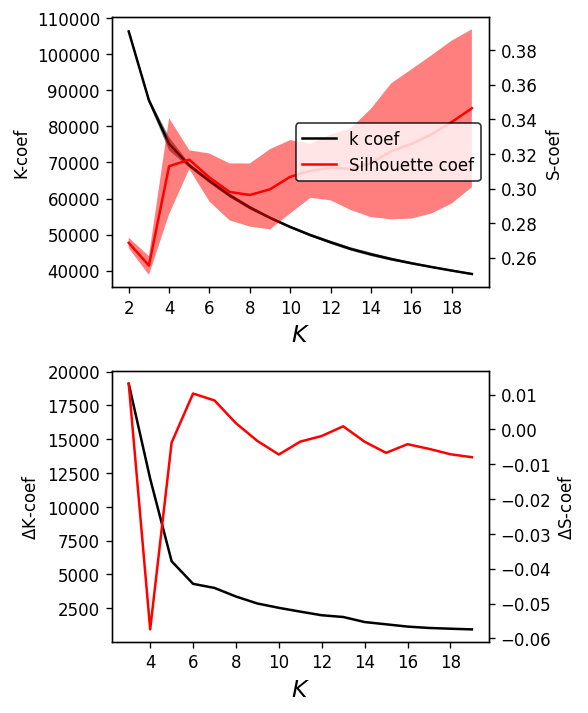

In [100]:
fig = draw_kmeans_summary(kobj_sub)
# utils.save_fig("kmeans_perform_sub", fdir="./fig")
plt.show()

### Consensus matrix

In [ ]:
from tqdm.notebook import tqdm

cmats_sub = [] # consensus matrix
for cid_set in tqdm(kobj_sub["cid_sets"]):
    cmats_sub.append(get_consensus_mat(cid_set))

  0%|          | 0/18 [00:00<?, ?it/s]

### CDF of consensus matrix

In [ ]:
cdf_sets_sub = []
edges = np.linspace(0, 1, 51)

for cm in cmats_sub:
    c, bins = np.histogram(cm.flatten(), bins=edges)
    pdf = c / (len(cm[0]))**2
    cdf_sets_sub.append(np.cumsum(pdf))
    

#### Draw CDF & PAC

save to ./fig/consensus_cdf_sub_2023921.png


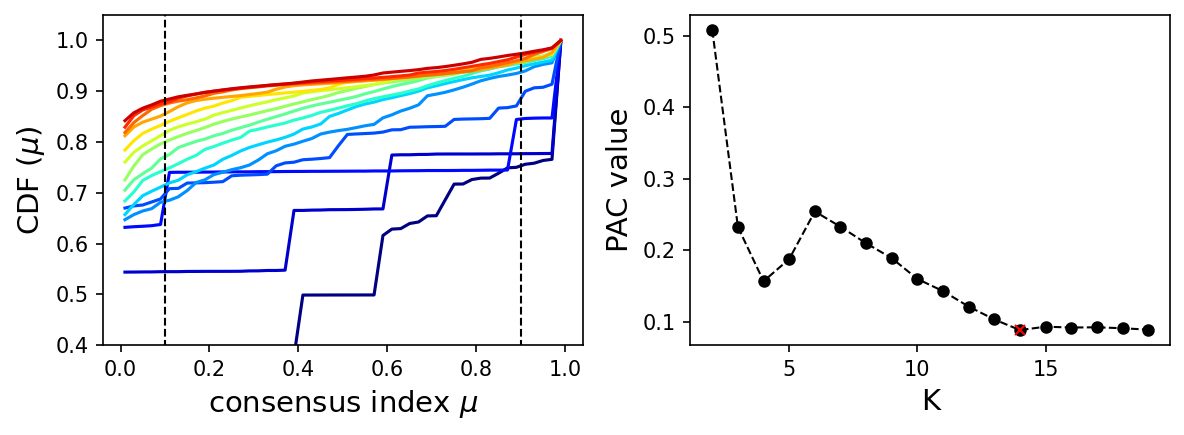

K = 14


In [ ]:
# ref: https://www.nature.com/articles/srep06207

cs = hhtools.get_palette("jet")
x = (edges[1:] + edges[:-1])/2

xwin = [0.1, 0.9]

pac_vals = []
for cdf in cdf_sets_sub:
    c0 = get_val(xwin[0], x, cdf)
    c1 = get_val(xwin[1], x, cdf)
    pac_vals.append(c1 - c0)

plt.figure(dpi=150, figsize=(8, 3))

plt.subplot(121)
for n in range(15):
    plt.plot(x, cdf_sets_sub[n], c=cs(n/15), lw=1.5)
plt.plot([xwin[0]]*2, [0, 1.1], 'k--', lw=1)
plt.plot([xwin[1]]*2, [0, 1.1], 'k--', lw=1)

plt.xlabel(r"consensus index $\mu$", fontsize=14)
plt.ylabel(r"CDF ($\mu$)", fontsize=14)
plt.ylim([0.4, 1.05])

plt.subplot(122)

nk = 12
num_clusters = kobj_tot["num_clusters"]

plt.plot(num_clusters, pac_vals, 'k.--', lw=1, ms=10)
plt.plot(num_clusters[nk], pac_vals[nk], 'rx', lw=1, ms=5)
plt.ylabel("PAC value", fontsize=14)
plt.xlabel("K", fontsize=14)
plt.tight_layout()

utils.save_fig("consensus_cdf_sub")
plt.show()

print("K = %d"%(num_clusters[nk]))

In [ ]:
# save proper K
data = dict(
    num_cluster=num_clusters[nk],
    consensus_mat=cmats_sub[nk],
    fdata="./data/kmeans_sub.pkl",
    date=utils.get_date_string()
)

with open("./data/kmeans_sub_opt_n2.pkl", 'wb')  as fp:
    pkl.dump(data, fp)

# Hierarchical clustering

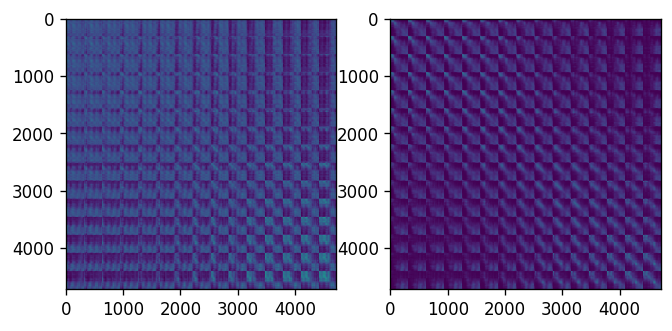

In [ ]:
with open("./data/kmeans_tot_opt_n2.pkl", 'rb') as fp:
    km_opt_tot = pkl.load(fp)
    
with open("./data/kmeans_sub_opt_n2.pkl", 'rb') as fp:
    km_opt_sub = pkl.load(fp)
    
plt.figure()
for n, obj in enumerate([km_opt_tot, km_opt_sub]):
    plt.subplot(1,2,n+1)
    plt.imshow(obj["consensus_mat"])
plt.show()

In [ ]:
# noramlizing data

sorted_mat, res_linkage, res_order = [], [], []
for n, obj in enumerate([km_opt_tot, km_opt_sub]):
    pmat = obj["consensus_mat"]

    smat, Z, ind = sort_matrix(pmat, method="ward")
    sorted_mat.append(smat)
    res_linkage.append(Z)
    res_order.append(ind)
    

convert to distance metric
convert to distance metric


save to ./fig/opt_consensus_matrix_2023921.png


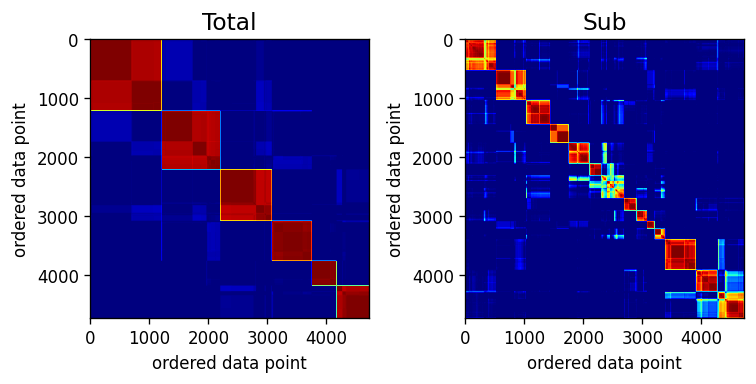

In [ ]:
titles = ["Total", "Sub"]

plt.figure()
for n in range(2):
    plt.subplot(1,2,n+1)
    plt.imshow(sorted_mat[n], cmap="jet")
    plt.title(titles[n], fontsize=14)
    plt.xlabel("ordered data point")
    plt.ylabel("ordered data point")
plt.tight_layout()

utils.save_fig("opt_consensus_matrix", fdir="./fig")
plt.show()

## Hierarchical clustering

In [ ]:
import hhclustering as hc

def hierarchical_clustering(dist_mat, num_clusters):
    from sklearn.cluster import AgglomerativeClustering 
    from scipy.spatial.distance import squareform
    
    if np.all(np.diag(dist_mat) == 1):
        print("convert to distance metric")
        dist_mat = 1 - dist_mat
    
    aggcluster = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
    cluster_id = aggcluster.fit_predict(dist_mat.copy())

    return cluster_id


def restore_permutation(permuted_arr, permuted_id):
    arr = np.zeros_like(permuted_arr)
    for n, nid in enumerate(permuted_id):
        arr[nid] = permuted_arr[n]
    return arr

In [ ]:
def draw_with_dendrogram(res_linkage, cmat, cluster_id):
    from scipy.cluster.hierarchy import dendrogram
    
    fig = plt.figure(dpi=120, figsize=(6, 6))
    fig.add_axes([0.15, 0.78, 0.65, 0.2])
    dendrogram(res_linkage, no_labels=True, color_threshold=0.5*max(res_linkage[:, 2])*0.4)
    plt.yscale("symlog")
    plt.xticks([]); plt.yticks([])
    plt.xlim([0, 47250])

    fig.add_axes([0.15, 0.75, 0.65, 0.03])
    plt.imshow(cluster_id.reshape((1, -1)), aspect="auto", cmap="Set3", interpolation="none")
    for cid in np.unique(cluster_id):
        x = np.where(cluster_id == cid)[0]
        plt.text(np.average(x), 0, "%d"%(cid), ha='center', va="center")
    plt.xticks([]); plt.yticks([])

    fig.add_axes([0.15, 0.1, 0.65, 0.65])
    plt.imshow(cmat, cmap="jet")

    # plt.show()
    return fig

In [ ]:
np.random.seed(1000)
permuted_cid_tot = hierarchical_clustering(sorted_mat[0], km_opt_tot["num_cluster"])

np.random.seed(1000)
permuted_cid_sub = hierarchical_clustering(sorted_mat[1], km_opt_sub["num_cluster"])

convert to distance metric


/home/jungyoung/.local/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


convert to distance metric


/home/jungyoung/.local/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [ ]:
reload(hc)

<module 'hhclustering' from '/home/jungyoung/Project/hh_neuralnet/dynamics_clustering/hhclustering.py'>

In [ ]:
# permuted_cid_tot = hierarchical_clustering(sorted_mat[0], km_opt_tot["num_cluster"])
# permuted_cid_sub = hierarchical_clustering(sorted_mat[1], km_opt_sub["num_cluster"])

# align cluster id
cluster_ids = []
id_old2new = []
for nid, p_cid in enumerate([permuted_cid_tot, permuted_cid_sub]):
    cid = restore_permutation(p_cid, res_order[nid])
    sq_cid_tmp = np.reshape(cid, (15, 15, 3, 7))
    sq_cid = sq_cid_tmp.copy()
    for nr in range(3):
        for nw in range(7):
            sq_cid[:, :, nr, nw] = hc.remove_cluster_island(sq_cid_tmp[:, :, nr, nw], nth=6)
    sq_cid, changed_id = hc.reorder_sq_cluster_id(sq_cid, start_id=1)
    cluster_ids.append(sq_cid.flatten())
    id_old2new.append(changed_id)
    
cluster_id_tot = cluster_ids[0]
cluster_id_sub = cluster_ids[1]
cluster_ids_types = ["tot", "sub"]

save to ./fig/consensus_clustering_tot_2023921.png


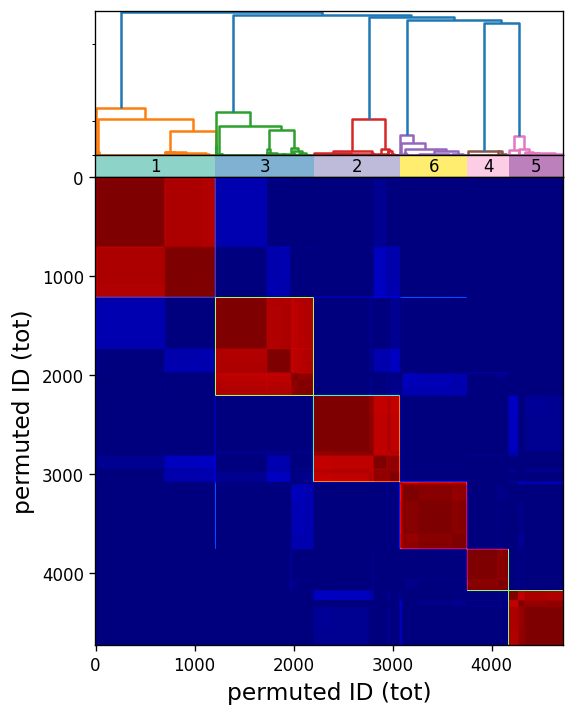

save to ./fig/consensus_clustering_sub_2023921.png


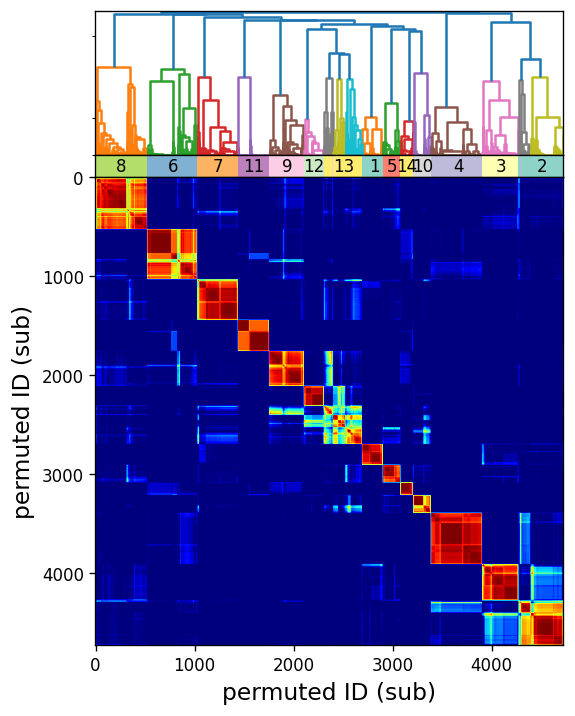

In [ ]:
def mapping(_mat, id_map):
    mat = np.zeros_like(_mat)
    for k, v in id_map.items():
        mat[_mat == k] = v
    return mat

# fig = draw_with_dendrogram(res_linkage[0], sorted_mat[0], cluster_id_tot[res_order[0]]) #permuted_cid_tot)
fig = draw_with_dendrogram(res_linkage[0], sorted_mat[0], mapping(permuted_cid_tot, id_old2new[0])) #permuted_cid_tot)
plt.xlabel("permuted ID (tot)", fontsize=14)
plt.ylabel("permuted ID (tot)", fontsize=14)
utils.save_fig("consensus_clustering_tot", fdir="./fig")
plt.show()

fig = draw_with_dendrogram(res_linkage[1], sorted_mat[1], mapping(permuted_cid_sub, id_old2new[1]))
plt.xlabel("permuted ID (sub)", fontsize=14)
plt.ylabel("permuted ID (sub)", fontsize=14)
utils.save_fig("consensus_clustering_sub", fdir="./fig")
plt.show()

#### Get congingency matrix

### Save data

In [ ]:
from importlib import reload
import xarray as xa

postdata = xa.load_dataarray("../three_pop_mpi/simulation_data/postdata.nc")

In [ ]:
align_tot = utils.load_pkl("./data/align_data_tot_n2.pkl")
align_sub = utils.load_pkl("./data/align_data_sub_n2.pkl")

sval_tot, scoef_tot = hc.get_silhouette_scores(align_tot["data"], cluster_id_tot)
sval_sub, scoef_sub = hc.get_silhouette_scores(align_sub["data"], cluster_id_sub)

### Check aligning

In [ ]:
def show_aligned_data(data, cluster_id, sval, yticks):
    
    def draw_line(bds):
        xl = plt.xlim()
        yl = plt.ylim()
        for b in bds:
            plt.plot([b]*2, yl, 'k', lw=0.5)
        plt.xlim(xl); plt.ylim(yl)
    
    data_o, _, bds = hc.reorder_data(data, cluster_id, sval)
    
    fig = plt.figure(figsize=(4, int(0.3*data_o.shape[0])), dpi=120)
    im = hc.hsmooth(data_o, wsize=15, fo=2)
    plt.imshow(im, cmap="jet", interpolation="none", aspect="auto", vmin=-3, vmax=3)
    draw_line(bds)
    plt.xticks([])
    plt.yticks()
    plt.xlabel("Data points", fontsize=14)
    plt.yticks(np.arange(im.shape[0]), labels=yticks)
    plt.colorbar(shrink=0.3, ticks=[-3, 0, 3])
    
    return fig

save to ./fig/./ordered_data_tot_n2_2023921.png


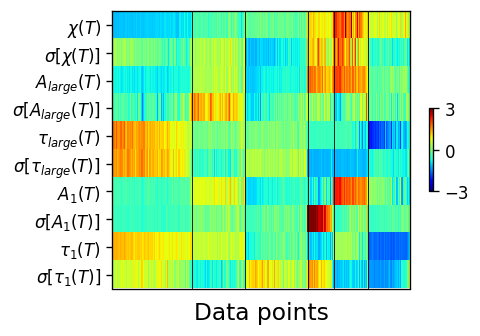

In [ ]:
fig = show_aligned_data(align_tot["data"], cluster_id_tot, sval_tot, align_tot["row_labels"])
utils.save_fig("./ordered_data_tot_n2", fdir="./fig")

save to ./fig/./ordered_data_sub_n2_2023921.png


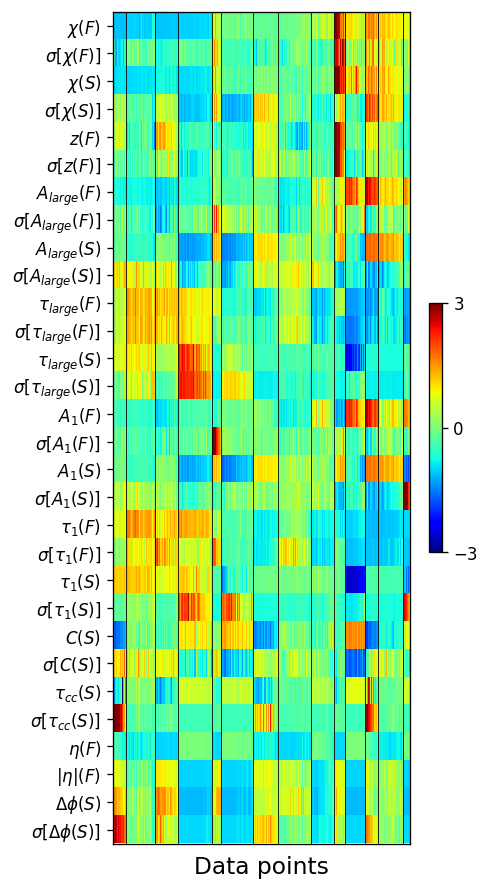

In [ ]:
show_aligned_data(align_sub["data"], cluster_id_sub, sval_sub, align_sub["row_labels"])
utils.save_fig("./ordered_data_sub_n2", fdir="./fig")

### save clusterd dataset

In [ ]:
dims = ("alpha", "beta", "rank", "w")
coords = coords=dict(
            alpha=postdata.coords["alpha"].data,
            beta=postdata.coords["beta"].data,
            rank=postdata.coords["rank"].data,
            w=postdata.coords["w"].data
        )
sz = (15, 15, 3, 7)

cid_dataset_tot = xa.Dataset(
    data_vars=dict(
        cluster_id=(dims, cluster_id_tot.reshape(*sz)),
        sval=(dims, sval_tot.reshape(*sz))
    ),
    coords=coords,
    attrs=dict(
        id_set=np.unique(cluster_id_tot),
        date=utils.get_date_string(),
        scoef=scoef_tot
    )
)


cid_dataset_sub = xa.Dataset(
    data_vars=dict(
        cluster_id=(dims, cluster_id_sub.reshape(*sz)),
        sval=(dims, sval_sub.reshape(*sz))
    ),
    coords=coords,
    attrs=dict(
        id_set=np.unique(cluster_id_sub),
        date=utils.get_date_string(),
        scoef=scoef_sub
    )
)


cid_dataset_tot.to_netcdf("./data/cluster_id_tot_n2.nc")
cid_dataset_sub.to_netcdf("./data/cluster_id_sub_n2.nc")

### Contingency table

In [ ]:
# @jit(nopython=True)
def gen_contingency_mat(cluster_id1, cluster_id2, sval1=None, sval2=None, sth=0.2):
    
    cid_set1 = np.sort(np.unique(cluster_id1)).astype(int)
    cid_set2 = np.sort(np.unique(cluster_id2)).astype(int)
    cont_mat = np.zeros((len(cid_set1), len(cid_set2)))
    
    N = len(cluster_id1)    
    for n in range(N):
        s1 = sval1[n] if sval1 is not None else 1
        s2 = sval2[n] if sval2 is not None else 1
        if s1 > sth and s2 > sth:
            c1 = int(cluster_id1[n]) - cid_set1[0]
            c2 = int(cluster_id2[n]) - cid_set2[0]
            cont_mat[c1, c2] += 1
    
    return cont_mat, cid_set1, cid_set2


def draw_contingency_table(cont_mat, cid_set1, cid_set2, cid_labels):
    def imshow_auto(im, **kwargs):
        plt.imshow(im, aspect="auto", **kwargs)
        
    def write_num(arr, dir="v"):
        for n, a in enumerate(arr):
            if dir == "v":
                plt.text(0, n, "%d"%(a), fontsize=14, ha="center", va="center")
            elif dir == "h":
                plt.text(n, 0, "%d"%(a), fontsize=14, ha="center", va="center")
                
    N = np.sum(cont_mat)
    
    ax_cont = plt.axes([0.1, 0.1, 0.7, 0.7])
    vmax = N/np.max([len(np.unique(cid_set1)), len(np.unique(cid_set2))])
    imshow_auto(cont_mat, cmap="gray", vmax=vmax, vmin=0)
    plt.xticks(np.arange(len(cid_set2)), labels=cid_set2)
    plt.yticks(np.arange(len(cid_set1)), labels=cid_set1)
    plt.ylabel("cluster ID (%s)"%(cid_labels[0]), fontsize=14)
    plt.xlabel("cluster ID (%s)"%(cid_labels[1]), fontsize=14)
    
    ax_sum1 = plt.axes([0.82, 0.1, 0.1, 0.7]) # right axis
    cont_sum1 = np.reshape([np.sum(cont_mat[nr, :]) for nr in range(len(cid_set1))], (-1, 1))
    imshow_auto(cont_sum1, vmin=0, cmap="jet")
    write_num(cont_sum1.flatten(), dir="v")
    plt.yticks([])
    plt.xticks([])
    
    ax_sum2 = plt.axes([0.1, 0.82, 0.7, 0.1]) # upper axis
    cont_sum2 = np.reshape([np.sum(cont_mat[:, nc]) for nc in range(len(cid_set2))], (1, -1))
    imshow_auto(cont_sum2, vmin=0, cmap="jet")
    write_num(cont_sum2.flatten(), dir="h")
    plt.yticks([])
    plt.xticks([])
    
    plt.axes([0.82, 0.82, 0.1, 0.1]) # corner (sum)
    plt.xlim([0, 1]); plt.ylim([0, 1])
    # plt.xticks([]); plt.yticks([])
    plt.text(0.5, 0.5, "%d"%(N), fontsize=14, va='center', ha='center')
    plt.axis("off")
    
    # # cont_sum2 = np.reshape([np.sum(cont_mat[:, nc]) for nc in range(len(cid_set2))], (1, -1))
    # sum_all = np.sum(cont_mat)
    # imshow_auto(cont_sum2, vmin=0, cmap="jet")
    # write_num(cont_sum2.flatten(), dir="h")
    # plt.yticks([])
    # plt.xticks([])
        

In [ ]:
cid_dataset_sub.cluster_id.data.flatten()

array([ 1.,  1.,  1., ...,  6., 11., 11.])

save to ./fig/contingency_matrix_2023921.png


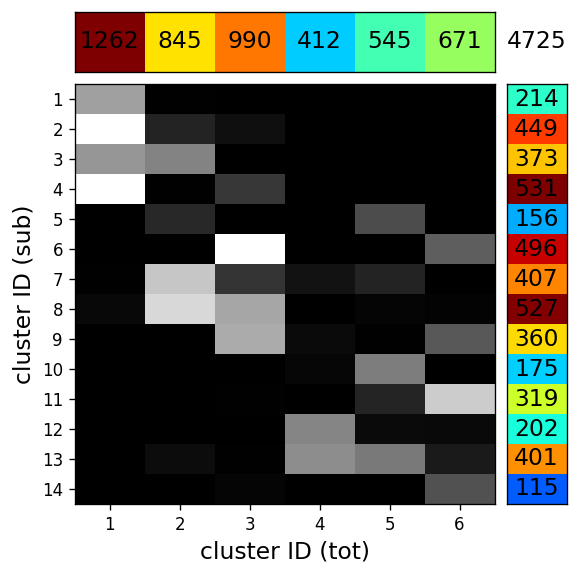

In [ ]:
cont_mat, cid_set_sub, cid_set_tot = gen_contingency_mat(cid_dataset_sub.cluster_id.data.flatten(), cid_dataset_tot.cluster_id.data.flatten())

plt.figure(dpi=120, figsize=(5, 5))
draw_contingency_table(cont_mat, cid_set_sub, cid_set_tot, ["sub", "tot"])
utils.save_fig("contingency_matrix", fdir="./fig")
plt.show()

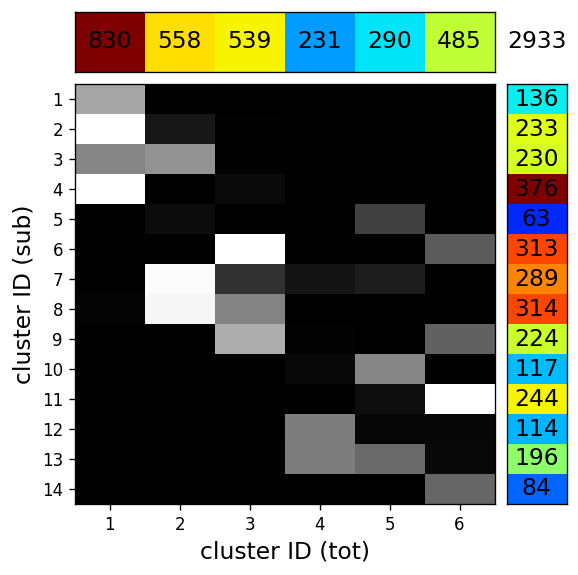

In [ ]:
cont_mat, cid_set_sub, cid_set_tot = gen_contingency_mat(cid_dataset_sub.cluster_id.data.flatten(),
                                                         cid_dataset_tot.cluster_id.data.flatten(),
                                                         cid_dataset_sub.sval.data.flatten(),
                                                         cid_dataset_tot.sval.data.flatten(), sth=0.1)

plt.figure(dpi=120, figsize=(5, 5))
draw_contingency_table(cont_mat, cid_set_sub, cid_set_tot, ["sub", "tot"])
# utils.save_fig("contingency_matrix", fdir="./fig")
plt.show()

## check align

# Clustering

In [94]:
# get lines
def get_im_boundary(im):
    nb = im.shape[0]
    lines = []
    
    def is_out(nr, nc):
        return (nc < 0) or (nc >=nb) or (nr < 0) or (nr >= nb)
    
    for i in range(nb):
        for j in range(nb):
            for d in ((-1, 0), (1, 0), (0, -1), (0, 1)):
                r, c = i+d[0], j+d[1]
                if is_out(r, c): continue
                
                if im[i, j] != im[r, c]:
                    if d[1] == 0:
                        lines.append([[j-0.5, j+0.5], [i+0.5*d[0], i+0.5*d[0]]])
                    else:
                        lines.append([[j+0.5*d[1], j+0.5*d[1]], [i-0.5, i+0.5]])
    return lines


def show_cluster_summary(cluster_id, max_cid=15, min_cid=1, sval=None, sth=0.2):
    
    len_p = 0.95/7
    len_r = 0.95/3

    xy = np.arange(15)

    lb_rank = ("Echelon 0", "Echelon 0.5", "Echelon 1")
    lb_w = [r"$\omega$=%.1f"%(x) for x in np.linspace(0.1, 1, 7)]
    
    lines_cluster = []
    for idp in range(7):
        for idr in range(3):
            lines_cluster.append(get_im_boundary(cluster_id[:, :, idr, idp]))

    ax_sets = []
    fig = plt.figure(dpi=120, figsize=(14, 6))
    for idp in range(7):
        ax_sets.append([])
        for idr in range(3):
            ax = plt.axes(position=[0.025+len_p*idp, 0.025+(2-idr)*len_r, len_p, len_r])
            ax_sets[-1].append(ax)
            
            # im = cluster_data["im_stacks"][idr][idp].astype(float)
            im = cluster_id[:, :, idr, idp].astype(float)
            im[0, 0] = np.nan
            
            if sval is not None:
                im[sval[:, :, idr, idp] < sth] = np.nan
            
            hc.show_sq_cluster(im, x=xy, y=xy, cmap="turbo", cth=2, vmin=min_cid, vmax=max_cid, fontsize=12, aspect="auto")
            for l in lines_cluster[idp*3+idr]:
                plt.plot(l[0], l[1], 'w', lw=1)
            
            plt.xticks([0, 7, 14], labels=["", "", ""])
            plt.yticks([0, 7, 14], labels=["", "", ""])
            plt.xlim([-0, 14]); plt.ylim([0, 14])
            
            if idp == 0:
                plt.ylabel(lb_rank[idr], fontsize=15, style="italic")
            
            if idr == 0:
                plt.title(lb_w[idp], fontsize=15, style="italic")
            
            for n, k in enumerate(("left", "right", "bottom", "top")):
                ax.spines[k].set_color("k")
                ax.spines[k].set_linewidth(1.5)

    # plt.show()
    return fig, ax_sets

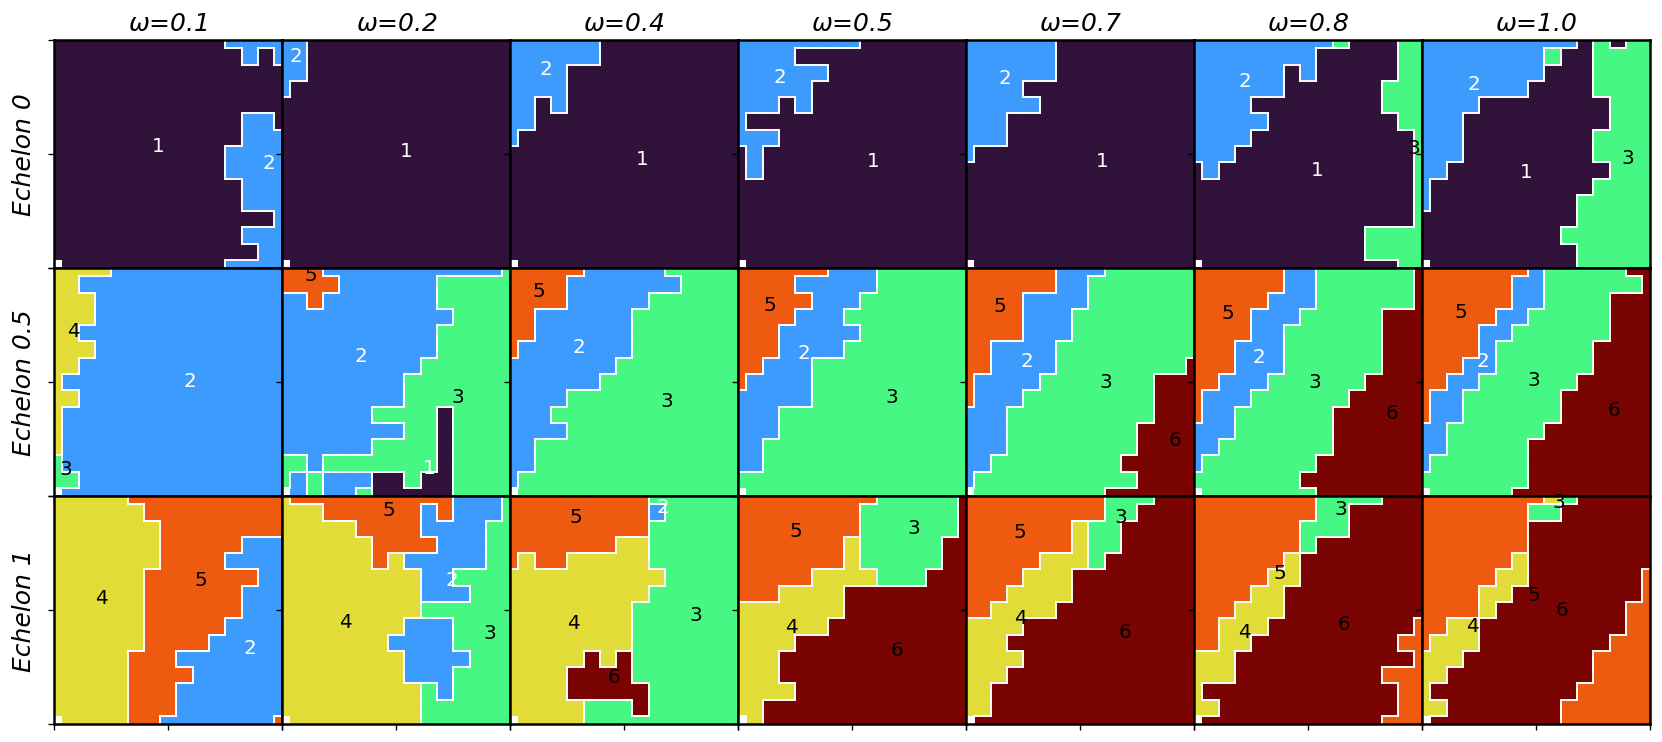

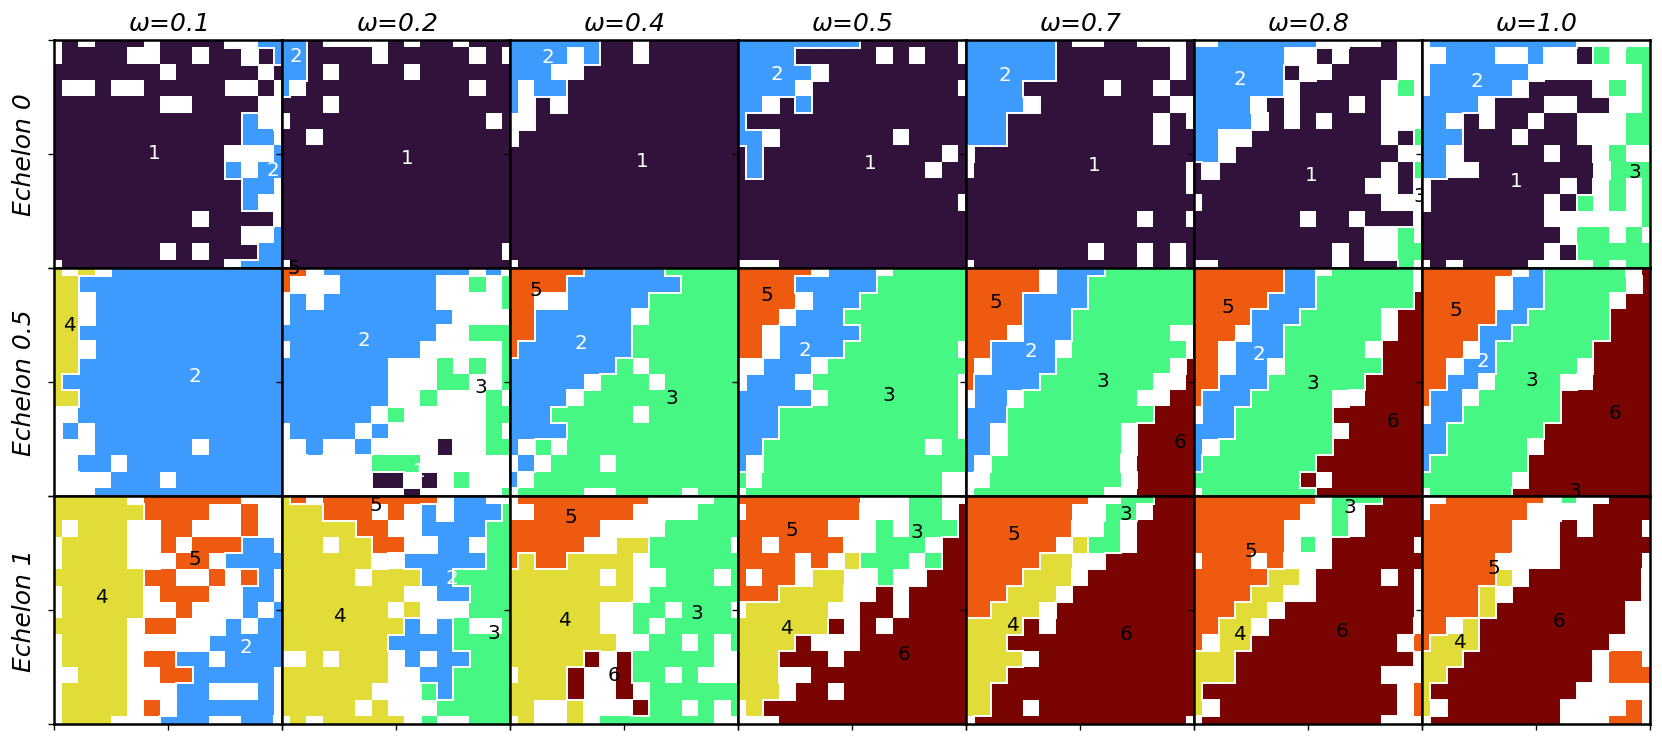

In [95]:
import xarray as xa
import hhclustering as hc

cid_array_tot = xa.load_dataset("./data/cluster_id_tot_n2.nc")
show_cluster_summary(cid_array_tot.cluster_id.data, max_cid=max(cid_array_tot.attrs["id_set"]))
plt.show()

show_cluster_summary(cid_array_tot.cluster_id.data, max_cid=max(cid_array_tot.attrs["id_set"]), min_cid=1,
                     sval=cid_array_tot["sval"], sth=0.1)
plt.show()

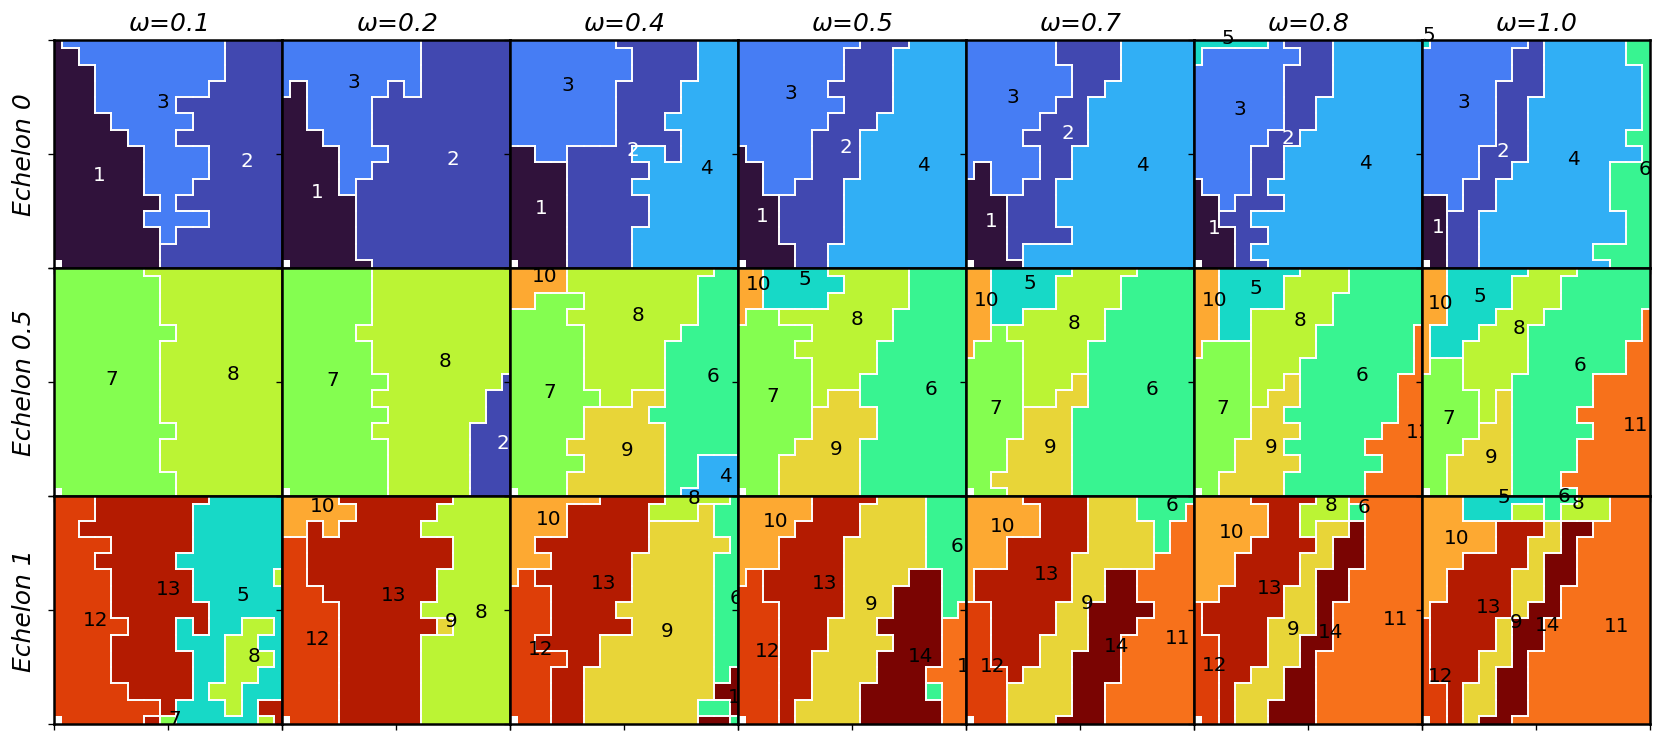

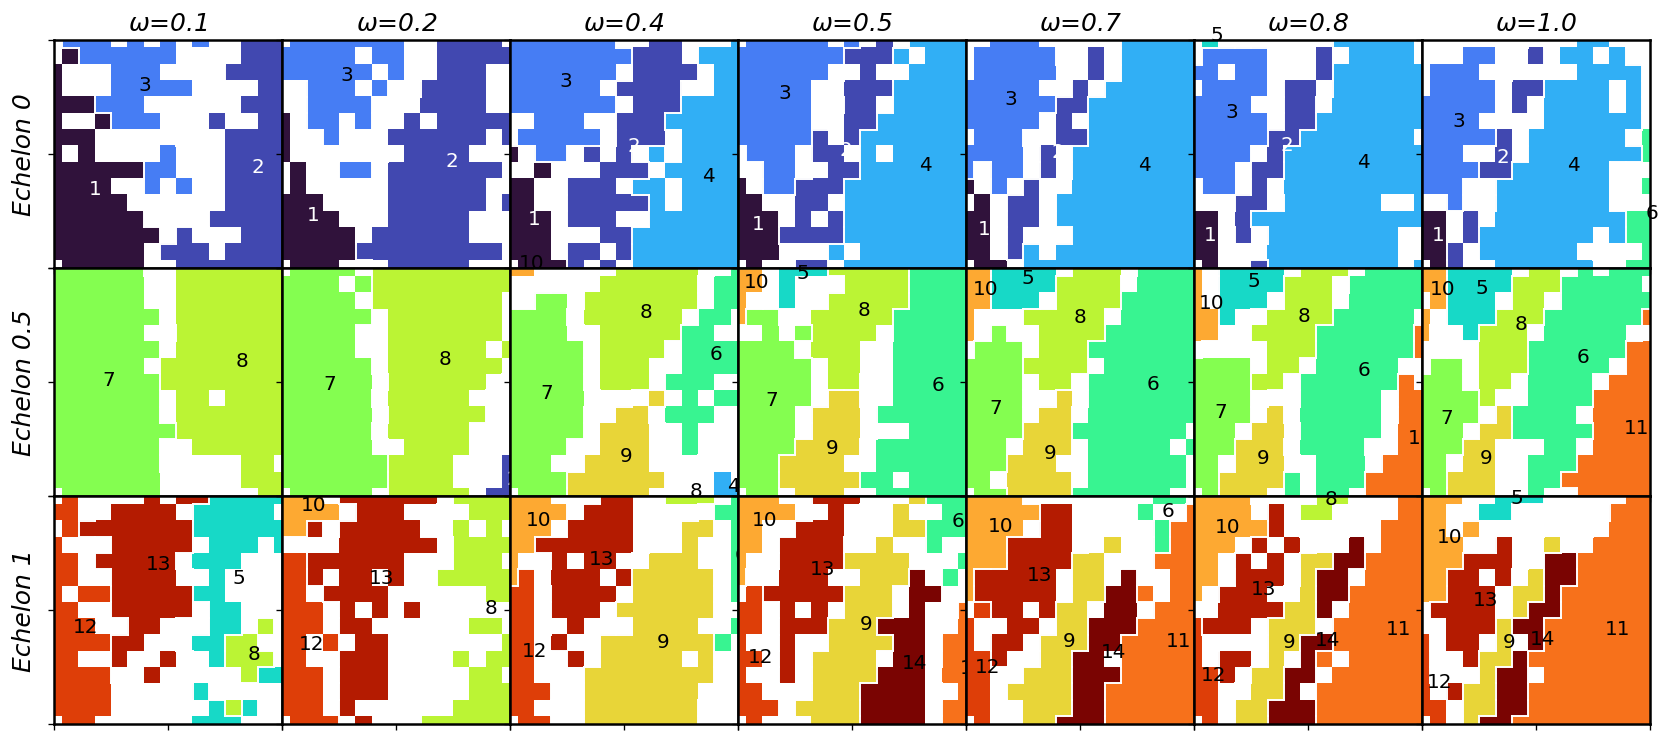

In [96]:
cid_array_sub = xa.load_dataset("./data/cluster_id_sub_n2.nc")
show_cluster_summary(cid_array_sub.cluster_id.data, max_cid=max(cid_array_sub.attrs["id_set"]))
plt.show()

show_cluster_summary(cid_array_sub.cluster_id.data, max_cid=max(cid_array_sub.attrs["id_set"]), min_cid=1,
                     sval=cid_array_sub["sval"], sth=0.1)
plt.show()

#### Compare with previous result

In [ ]:
import xarray as xa

with open("./data/rcluster_nrank3_inc_im.pkl", "rb") as fp:
    cid_prev = pkl.load(fp)
    
    
cid_dataset_sub = xa.load_dataset("./data/cluster_id_sub_n2.nc")
cid_dataset_tot = xa.load_dataset("./data/cluster_id_tot_n2.nc")

In [ ]:
cid_prev_align = np.zeros_like(cid_dataset_sub.cluster_id.data)
for idr in range(3):
    for idp in range(7):
        cid_prev_align[:, :, idr, idp] = cid_prev["im_stacks"][idr][idp]

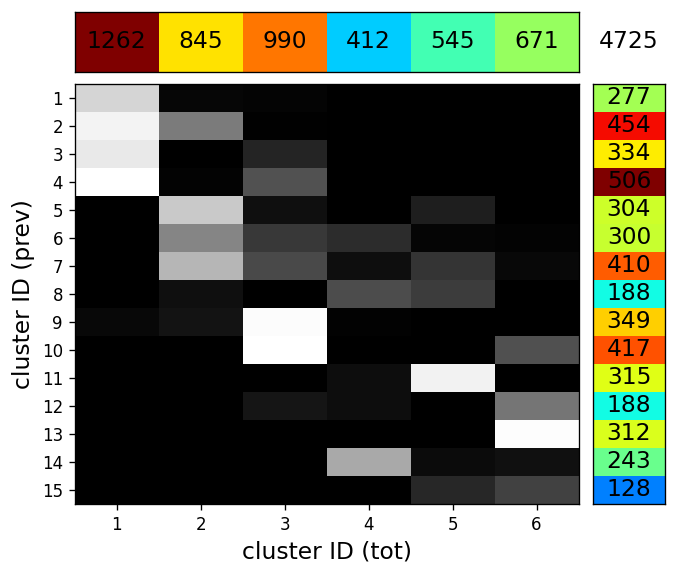

In [ ]:
cont_mat, cid1, cid2 = gen_contingency_mat(
    cid_prev_align.flatten(),
    cid_dataset_tot.cluster_id.data.flatten()
)

plt.figure(dpi=120, figsize=(6, 5))
draw_contingency_table(cont_mat, cid1, cid2, ["prev", "tot"])
plt.show()

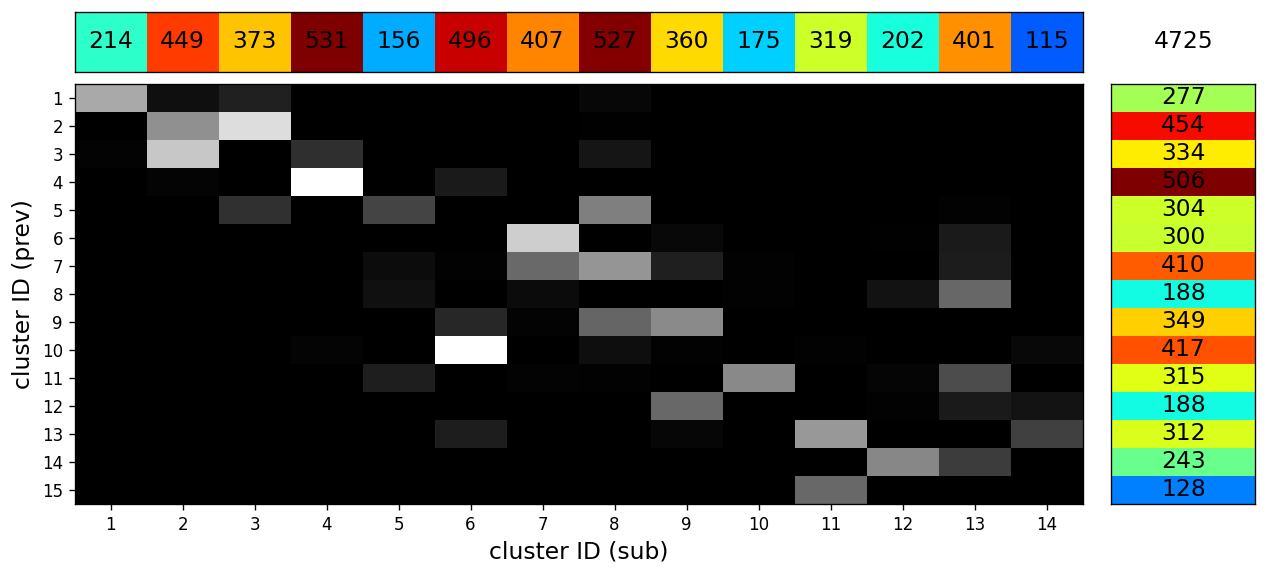

In [ ]:
cont_mat, cid1, cid2 = gen_contingency_mat(
    cid_prev_align.flatten(),
    cid_dataset_sub.cluster_id.data.flatten()
)

plt.figure(dpi=120, figsize=(12, 5))
draw_contingency_table(cont_mat, cid1, cid2, ["prev", "sub"])
plt.show()

## Check best points location picked in the prev clusters

In [8]:
with open("./data/cluster_repr_points_rank3.pkl", 'rb') as fp:
    loc_data = pkl.load(fp)
    print(loc_data["desc"])

with open("./data/picked_cluster.txt", "r") as fp:
    line = fp.readline()
    line = fp.readline()
    psets = []
    while line:
        psets.append(list(map(int, line.split(",")[:-1])))
        line = fp.readline()

nrow, ncol, nrank, nw


In [30]:
loc_use = np.zeros([15, 15])
for pinfo in psets:
    nc = pinfo[0]-1
    n = pinfo[1]
    
    pt = loc_data["loc_points"][nc][n]
    loc_use[pt[0], pt[1]] += 1
    

/home/jungyoung/Project/hh_neuralnet/dynamics_clustering/hhclustering.py:525: RuntimeWarning: invalid value encountered in cast
  cids = [c for c in np.unique(sq_cluster).astype(int) if c > 0]


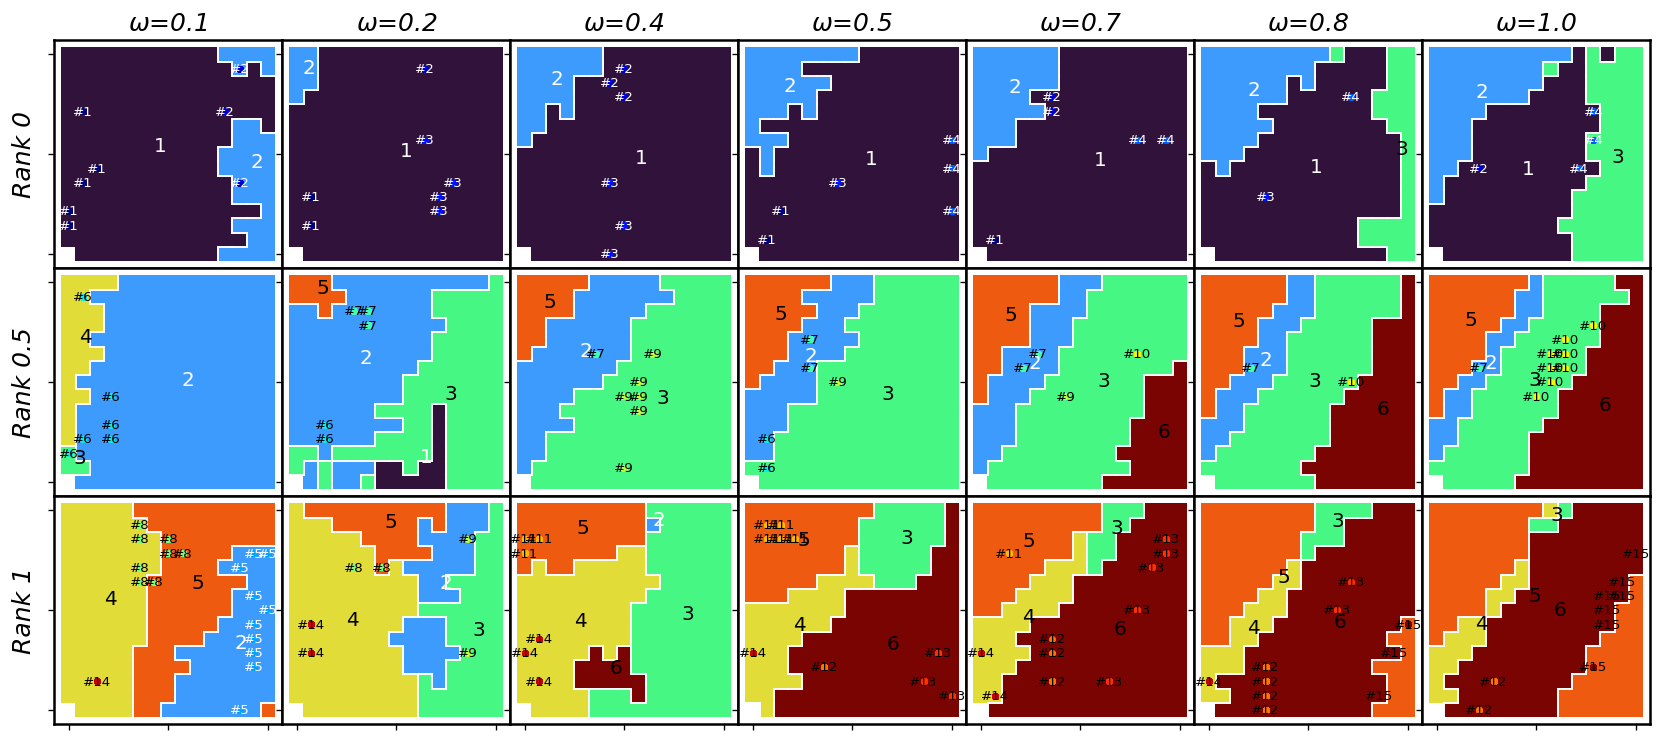

In [91]:
fig, ax_sets = show_cluster_summary(cid_array_tot.cluster_id.data, max_cid=max(cid_array_tot.attrs["id_set"]))

for nw in range(7):
    for nr in range(3):
        ax_sets[nw][nr].set_xlim([-1, 15])
        ax_sets[nw][nr].set_ylim([-1, 15])


cset = hhtools.get_palette("jet")

nc_cur, nused = 0, []
for pt in psets:
    # cluster_id, loc, rank
    nc = pt[0] - 1
    ny, nx, nrank, nw = loc_data["loc_points"][nc][pt[1]]
    if nr != pt[2]:
        ValueError("Rank does not match")
        
    if nc_cur != nc:
        nc_cur = nc
        nused = []

    ax_sets[nw][nrank].plot(nx, ny, '.', c=cset(nc/14))
    
    if pt[1] not in nused:
        c = "w" if nc < 5 else "k"
        ax_sets[nw][nrank].text(nx, ny, "#%d"%(nc+1), color=c, ha="center", va="center", fontsize=8)
        nused.append(pt[1])
    

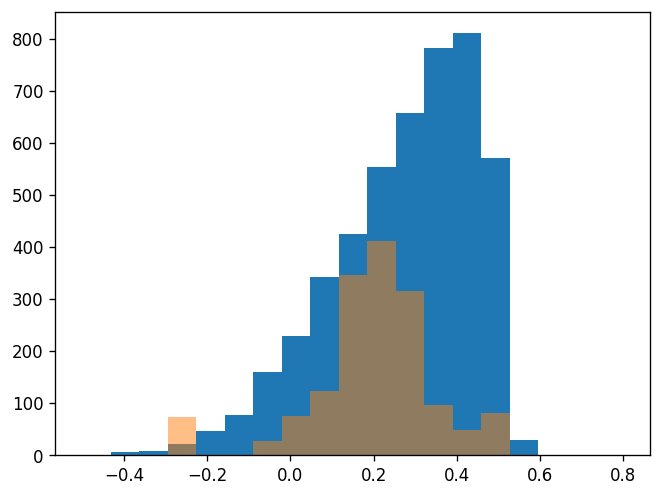

In [88]:
svals_tot = cid_array_tot.sval.data.flatten()

svals_prev = []
for pt in psets: # cluster_id, loc, rank
    nc = pt[0] - 1
    ny, nx, nrank, nw = loc_data["loc_points"][nc][pt[1]]
    
    if nc+1 not in [4, 9, 14, 15]:
        continue
    
    sval = cid_array_tot.sval.isel(dict(alpha=ny, beta=nx, rank=nrank, w=nw)).data
    svals_prev.append(sval)
    
bins = np.linspace(-0.5, 0.8, 20)

plt.figure()
plt.hist(svals_tot, alpha=1, bins=bins, density=False)
plt.hist(svals_prev, alpha=0.5, bins=bins, density=False)
plt.show()

/home/jungyoung/Project/hh_neuralnet/dynamics_clustering/hhclustering.py:525: RuntimeWarning: invalid value encountered in cast
  cids = [c for c in np.unique(sq_cluster).astype(int) if c > 0]


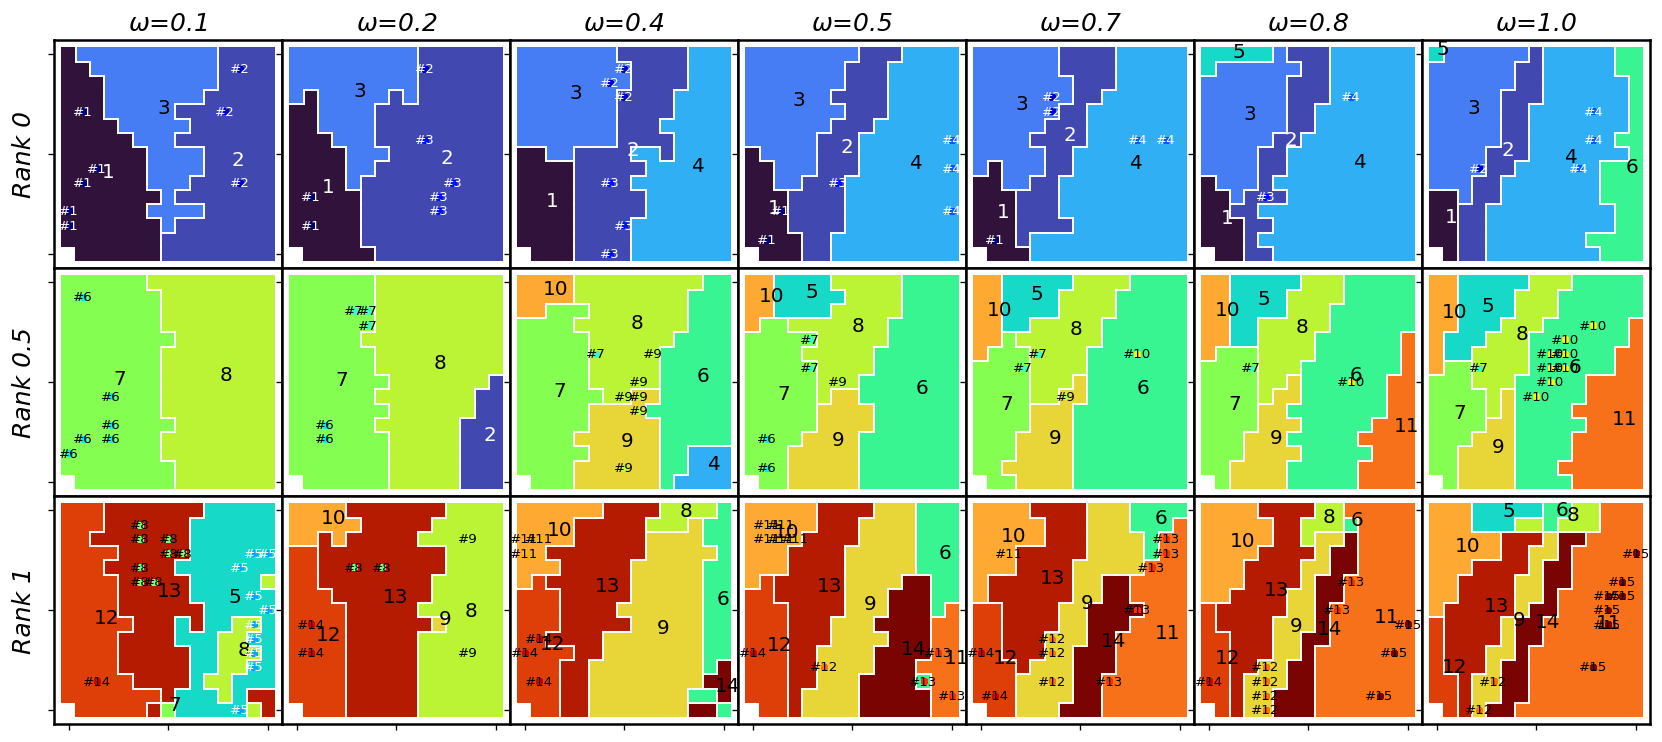

In [93]:
fig, ax_sets = show_cluster_summary(cid_array_sub.cluster_id.data, max_cid=max(cid_array_sub.attrs["id_set"]))

for nw in range(7):
    for nr in range(3):
        ax_sets[nw][nr].set_xlim([-1, 15])
        ax_sets[nw][nr].set_ylim([-1, 15])


cset = hhtools.get_palette("jet")

nc_cur, nused = 0, []
for pt in psets:
    # cluster_id, loc, rank
    nc = pt[0] - 1
    ny, nx, nrank, nw = loc_data["loc_points"][nc][pt[1]]
    if nr != pt[2]:
        ValueError("Rank does not match")
        
    if nc_cur != nc:
        nc_cur = nc
        nused = []

    ax_sets[nw][nrank].plot(nx, ny, '.', c=cset(nc/14))
    
    if pt[1] not in nused:
        c = "w" if nc < 5 else "k"
        ax_sets[nw][nrank].text(nx, ny, "#%d"%(nc+1), color=c, fontsize=8, ha="center", va="center")
        nused.append(pt[1])
    

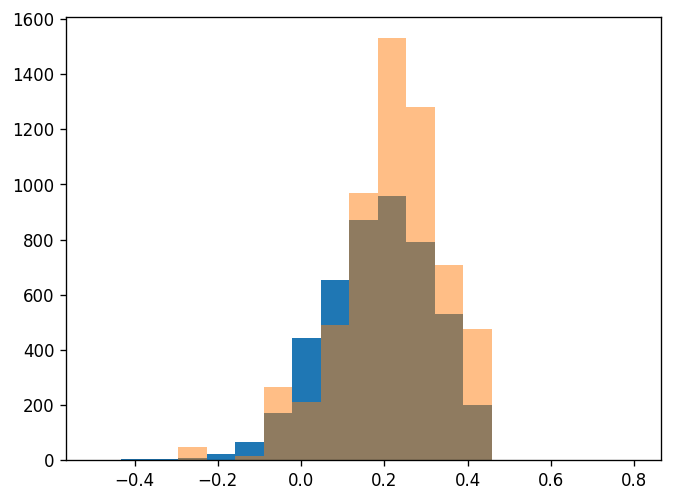

In [87]:
svals_tot = cid_array_sub.sval.data.flatten()

svals_prev = []
for pt in psets: # cluster_id, loc, rank
    nc = pt[0] - 1
    ny, nx, nrank, nw = loc_data["loc_points"][nc][pt[1]]
    
    sval = cid_array_sub.sval.isel(dict(alpha=ny, beta=nx, rank=nrank, w=nw)).data
    svals_prev.append(sval)
    
bins = np.linspace(-0.5, 0.8, 20)

plt.figure()
plt.hist(svals_tot, alpha=1, bins=bins, density=False)
plt.hist(svals_prev, alpha=0.5, bins=bins, density=False)
plt.show()